# Orientation Tuning & Curve Fits for Neuronal Firing

In [1]:
#Initializer block
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sci
import scipy as sci
from scipy.io import loadmat
import pandas as pd

### Problem (2a) & (2b)

The number of action potentials are n =  459


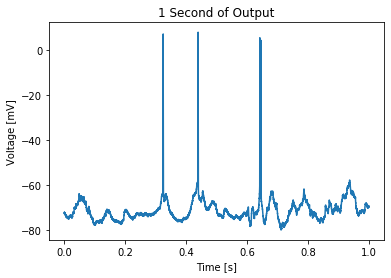

In [2]:
mat = loadmat('orientation_tuning_data.mat')

time = 1 #how many seconds of data in the "snapshot"
n = 0 #number of action potentials

times = mat["Stimuli"][:,1]/10000 #list for timestamps of stimuli insertions [s]
Vm = (mat['Vm'])[0] #list for voltages; measured in 10kHz
spikes = [] #empty list for spike times

for k in range(len(Vm)-1):
    if (Vm[k] < -20 and Vm[k+1] > -20): #if voltage before is < -20 and the next is > -20, then spike
        n += 1;
        spikes.append(k/10000) #appending the time [s] at which the spike occured; each Vm measured at 10kHz
        
plt.plot(np.linspace(0,time,time*10000),Vm[:time*10000]) #plotting 1 second vs mV
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]");
plt.title("1 Second of Output")

print("The number of action potentials are n = ", n)

### Problem (2c) 

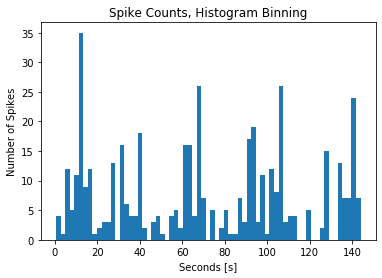

<Figure size 432x288 with 0 Axes>

In [3]:
"""
A standard histogram with arbitrarily defined bines at each of the timestamps
"""

Vms = pd.DataFrame(Vm,columns = ["Voltages [Hz]"]) #dataframe of the voltages measured [kHz]

(n,bins,c) = plt.hist(spikes,bins = times);
plt.xlabel("Seconds [s]")
plt.ylabel("Number of Spikes")
plt.title("Spike Counts, Histogram Binning")

plt.figure();

In [4]:
"""
Convert the instances of spikes to a list of 1s and 0s -> forming a spike train
"""

Vms = pd.DataFrame(Vm,columns = ["Voltages"]) #dataframe of the voltages measured [kHz]
spikeCount = []; #stores the index value in which there is a spike
spikeTrain = np.zeros(len(Vms["Voltages"])) #spike = 1; no spike = 0

for k in range(len(Vm)-1):
    if(Vm[k] < -20 and Vm[k+1] > -20):
        spikeTrain[k] = 1; #for the location of the action potential, mark the spikeTrain

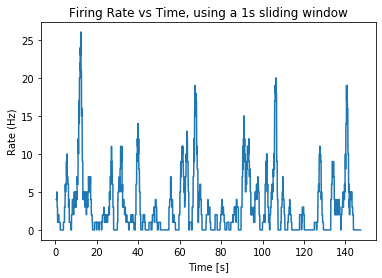

In [5]:
"""
Run a rolling window of length 1s through the spike train
"""

df = pd.DataFrame(spikeTrain,columns=["Spike Train"])

dp = df["Spike Train"].rolling(10000,center=True).sum() #runs a rolling window through the binary spike train
dp.columns = ["Windows"]

counts = dp.value_counts()
timess = len(dp[:])

plt.plot(np.linspace(0,timess,timess)/10000,dp[:])
plt.xlabel("Time [s]")
plt.ylabel("Rate (Hz)")
plt.title("Firing Rate vs Time, using a 1s sliding window");

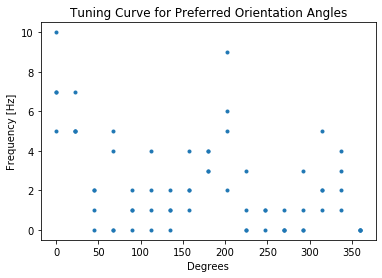

In [6]:
orientations = mat["Stimuli"][:,0] #orientation of neuron; from data

dataaa = {"Times": times,
          "Orientations": orientations*22.5}

dfs = pd.DataFrame(dataaa) #dataframe storing the timestamps and orientations of the neuron/stimuli
countList = []; #empty list to store the window counts

"""
Find the index corresponding to each timestamp and add the window count at each timestamp to list 'countList'
"""
for k in range(len(times)): #find the window value of counts corresponding to the index of the timestamp
    i = int(dfs["Times"][k]*10000);
    countList.append(dp[i])

dfs = dfs.assign(Rates = countList)

plt.plot(dfs['Orientations'],dfs['Rates'],'.')
plt.xlabel("Degrees")
plt.ylabel("Frequency [Hz]");
plt.title("Tuning Curve for Preferred Orientation Angles");

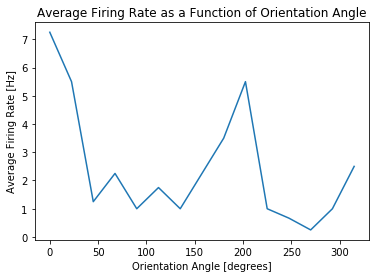

In [7]:
"""
Take firing rates and average each of the instances in which the orientation angle is the same. 
Reset the index after for easy modeling.
"""
averagedData = dfs.groupby("Orientations").mean().reset_index();

plt.plot(averagedData["Orientations"][:15],averagedData["Rates"][:15]);
plt.xlabel("Orientation Angle [degrees]")
plt.ylabel("Average Firing Rate [Hz]")
plt.title("Average Firing Rate as a Function of Orientation Angle");

This seems to me that the two spikes occur at 0 degrees and 180 degrees. This suggests that for whatever the optimal orientation is, a 180 degree flip will have no effect on things. I.e. the neuron is capable of generating an action potential at some x angle and its flipped alternative, i.e. x + 180 degrees.

## 2d (Extra credit) (See all cells below)

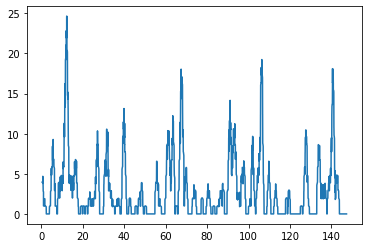

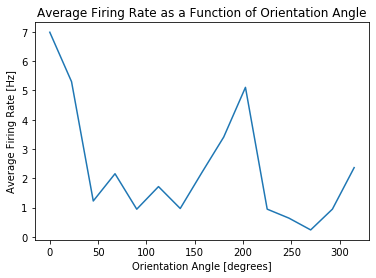

In [8]:
"""
Run a rolling Gaussian window through the spike train. Also implemented a Gaussian fit to the original data.
"""

df = pd.DataFrame(spikeTrain,columns=["Spike Train"])

gaussian = df["Spike Train"].rolling(10000,win_type="gaussian",center=True).sum(std=10000) 

dataaa = {"Times": times,
          "Orientations": orientations*22.5}

dfs_gauss = pd.DataFrame(dataaa) #dataframe storing the timestamps and orientations of the neuron/stimuli
countList = [];

"""
Find the index corresponding to each timestamp and add the window count at each timestamp to list 'countList'
"""
for k in range(len(times)):
    i = int(dfs["Times"][k]*10000);
    countList.append(gaussian[i])
   
dfs_gauss = dfs_gauss.assign(Rates = countList)

"""
Take firing rates and average each of the instances in which the orientation angle is the same. 
Reset the index after for easy modeling.
"""
averagedGaussData = dfs_gauss.groupby("Orientations").mean().reset_index();
    
plt.plot(np.linspace(0,timess,timess)/10000,gaussian)

plt.figure();

plt.plot(averagedGaussData["Orientations"][:15],averagedGaussData["Rates"][:15])

plt.xlabel("Orientation Angle [degrees]")
plt.ylabel("Average Firing Rate [Hz]")
plt.title("Average Firing Rate as a Function of Orientation Angle");

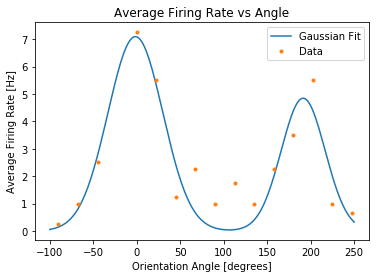

In [9]:
"""
Gaussian Fit:
We note that there are two peaks to the original sliding window data, and 
thus, we could try to fit a sum of two gaussians to this curve.
"""

from scipy import optimize
xs = averagedData["Orientations"][:15]
ys = averagedData["Rates"][:15]

temp, tempy = pd.DataFrame(0-360+xs[12:]), pd.DataFrame(ys[12:])
xss, yss = pd.DataFrame(xs[:12]),pd.DataFrame(ys[:12])
xss, yss = np.squeeze(temp.append(xss).reset_index().drop("index",axis=1)), np.squeeze(tempy.append(yss).reset_index().drop("index",axis=1))
 
amplitude1,center1,sigma1, amplitude2,center2,sigma2 = 5.8,180,20, 7,0,20

def gaussianFitter(x, amplitude1,center1,sigma1, amplitude2,center2,sigma2):
    return amplitude1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-center1)/sigma1)**2))) + \
            amplitude2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-center2)/sigma2)**2)))

popt_2gauss, pcov_2gauss = sci.optimize.curve_fit(gaussianFitter, xss, yss, p0=[amplitude1,center1,sigma1, amplitude2,center2,sigma2])

xvals = np.linspace(-100,250,200)
plt.plot(xvals,gaussianFitter(xvals,*popt_2gauss),label="Gaussian Fit") #plot of Gaussian
plt.plot(xss,yss,".",label="Data"); #plot of original points
plt.xlabel("Orientation Angle [degrees]")
plt.ylabel("Average Firing Rate [Hz]")
plt.title("Average Firing Rate vs Angle")
plt.legend();